In [1]:
# For ease of use, the mpas-analysis conda environment can be installed, 
# which includes most of the following packages.

# xeofs, rioxarray will be required as additional packages.
# cmocean colormaps may be required, if plotting the EOF mode figures.

import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections

import cartopy.crs as ccrs
import cartopy
#import cartopy.mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import scipy
from scipy import signal
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import geopandas as gpd
import cmocean

# NOTE:
# This version of the code uses a modified version of the xeofs package which can be downloaded here:
# https://github.com/mshiv/xeofs-rand
# Future versions with refactored codebase can be found at https://github.com/mshiv/aislens_emulation

In [2]:
# To update following with relative repository paths once data and code is up on Zenodo
# Current version uses the project template on Github.

# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS
# Data containing regridded flux and SSH for 150 years
# The input dataset is a 3 dimensional NETCDF file with ('time','y','x') dimensions.
# 'y','x' are used here as the data is gridded in polar stereographic coordinates.

# The variable resolution dataset used in this study can be downloaded from
# https://esgf-node.llnl.gov/search/e3sm/ (for V1 Cryosphere Campaign)
# The current workflow in this notebook is set up for a constant resolution grid in space and time, 
# so the MPAS-Ocean dataset should be regridded. These steps are provided in separate Python scripts,
# which assume the user has access to MPAS-Ocean output.


regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'
regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

# Ice shelf boundary definitions: https://github.com/MPAS-Dev/geometric_features
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

interim_data_folder = 'data/interim/'
processed_data_folder = 'data/processed/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'
std_file_path = 'standardized_rec_data/'


pca_1 = '1_pca/'
pca_2 = '2_pca_normalized/'
pca_3 = '3_pca_normalized_nmodes/'
pca_4 = '4_lowpass_ pca_normalized/'

# Dedrafted flux
iceshelves_dedrafted_total = xr.open_dataset(inDirName+
                                             interim_data_folder+
                                             flux_dedrafted_iceshelves_data_path+
                                             'iceshelves_dedrafted_total.nc')

flux_dedraft = iceshelves_dedrafted_total.timeMonthly_avg_landIceFreshwaterFlux

# Demean: remove temporal mean
flux_dedraft_tmean = flux_dedraft.mean('time')
flux_dedraft_demeaned = flux_dedraft - flux_dedraft_tmean

In [3]:
# Original forcing data: raw MPAS-O output, mapped to the 10km resolution grid
# flux is freshwater flux
# ssh is sea surface height, used here as a proxy for ice draft / depth.

# ssh is used to plot the scatterplot of flux vs. draft for different ice shelves 
# and as input for the linear regression used in "dedrafting" the dataset

sec_per_year = 365*24*60*60
rho_fw = 1000

# Pre-processed data: detrended, deseasonalized, dedrafted
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Flux datapoints extracted for individual ice shelves, used for the scatter plots
catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")
catchments_scatter_xr = xr.DataArray(catchments_scatter,dims={'basin','x','y'})
catchments_scatter = catchments_scatter*sec_per_year/rho_fw

# Catchment boundary masks for Antarctica, taken from ice shelf definitions in MPAS-Dev/geometric-features:
# https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data
# These have been combined into one file with 133 defined regions (polygons and multipolygons), 
# readable via the Geopandas package

# Read geoJSON region feature file as a GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + interim_data_folder + 'iceShelves.geojson')

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

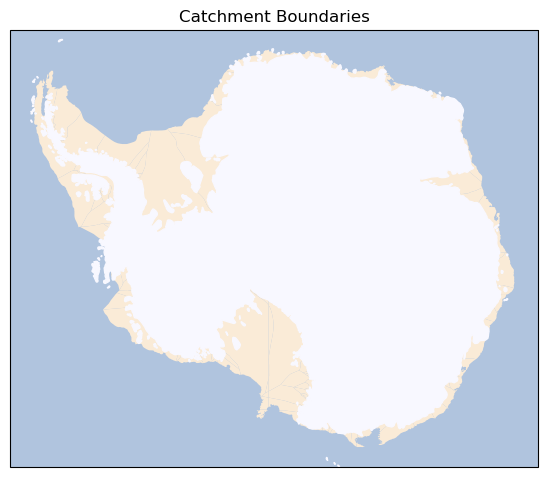

In [4]:
# Plot boundaries

plt.figure(figsize=(15,15))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
#ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

### Sample data for specific ice shelves (time averaged melt rate draft dependence)

Scatterplot of Antarctic catchments

AttributeError: module 'cartopy' has no attribute 'mpl'

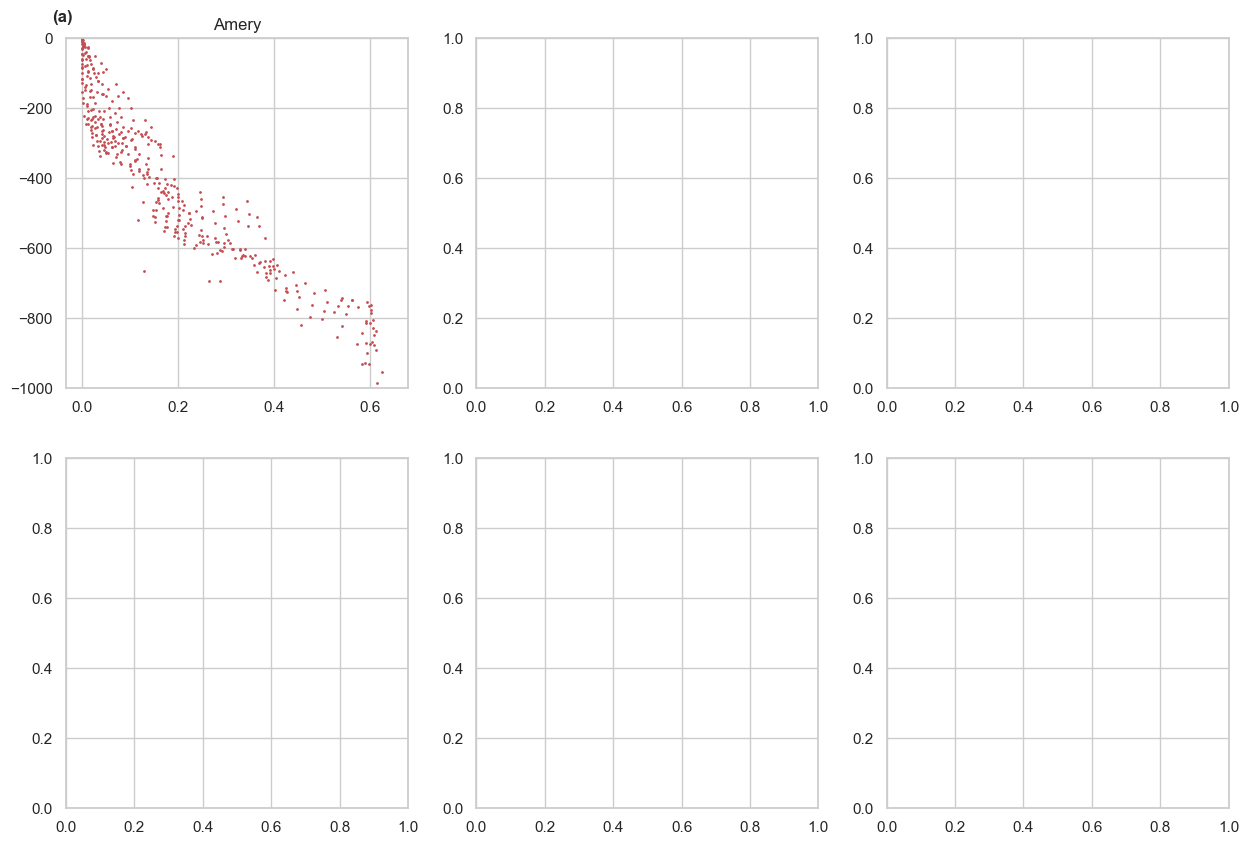

In [4]:
# Figure: Melt rate draft dependence for select catchments
# The following indices are taken from 'catchment_scatter', defined as
# Index of catchments in catchment_scatter = Index of catchments in icems - 33

# Sample ice shelves chosen:
# Amery = 1
# George VI = 27
# Getz = 28
# Pine Island = 61
# Ronne = 70
# Totten = 83
# Wilkins = 94
# Western Ross = 71
# Filchner = 22
# Thwaites = 81
# Eastern_Ross = 72

# Full list of ice shelves and indices can be obtained by printing icems

#catchments = np.array([1,27,28,61,70,83,94,71,22])

catchments = np.array([1,27,28,61,70,83])
basins=catchments+33

sns.set_theme(style="whitegrid")
#fig, ax = plt.subplots(1, 1, figsize=[15, 15],subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig, axs = plt.subplots(2,3, figsize=[15, 10])
axs=axs.ravel()

for i,label in enumerate(('(a)', '(b)', '(c)', '(d)', '(e)', '(f)')):
    axs[i].scatter(catchments_scatter[catchments[i]],ssh[1],color='r',s=1)
    #axs[i].set_xlabel('Melt Flux (kg / m2 / s)')
    #axs[i].set_ylabel('Depth (m)')
    axs[i].set_ylim(-1000,0) # Specified for consistency across plots, some catchments are not as deep as others
    # Uncomment to set xlim values for easy comparison of forcing magnitudes (varies across ice shelves)
    #axs[i].set_xlim(-0.5e-6,2e-5)
    axs[i].set_title('{}'.format(icems.name[33+catchments[i]]))
    axs[i].text(-0.04, 1.08, label, transform=axs[i].transAxes ,fontweight='bold', va='top')
    # axs[i].inset_axes([], projection=crs) does not seem to work, hence the workaround below:
    # Refer here: https://github.com/matplotlib/matplotlib/pull/22608 for future revisions
    axins = inset_axes(axs[i],width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='r',linewidth=0.4)
    #axs[i].set_axis_off();
    axins.set_axis_off();
    axs[i].grid(alpha=0.5)

axs[0].set_ylabel('Depth (m)');
axs[3].set_ylabel('Depth (m)');

axs[3].set_xlabel('Melt Rate ($m/yr$)');
axs[4].set_xlabel('Melt Rate ($m/yr$)');
axs[5].set_xlabel('Melt Rate ($m/yr$)');

# Data Pre-Processing

For time series plots and comparisons, the sum of flux across the spatial domain (or specific ice shelves) is used as a proxy when required. The mean can also be used here, without any loss of information, as the idea is only to compare trendlines.

However, this might not be possible once the data is normalized, as the magnitude of data is removed at that stage.

In [4]:
# Demean: remove temporal mean
# A pre-processed ("dedrafted") dataset is provided with this code. 
# In case of a linear regression, the xarray.polyfit or xarrayutils functions can be used:
# https://docs.xarray.dev/en/stable/generated/xarray.Dataset.polyfit.html
# https://xarrayutils.readthedocs.io/en/latest/utils.html

flux_dedraft_tmean = flux_dedraft.mean('time')
flux_dedraft_demeaned = flux_dedraft - flux_dedraft_tmean

# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux_dedraft_demeaned.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

# Remove initial 'model spinup period' data before analysis
spinup_period_years = 25 # Verify period of datapoints to be removed before PCA
spinup_time_period = 12*spinup_period_years
#flux_clean = flux_anm[spinup_time_period:]

flux_seasonal = (flux_dedraft - flux_anm)*sec_per_year/rho_fw
flux_drft = (flux - flux_dedraft)*sec_per_year/rho_fw

flux_seasonal = flux_seasonal[spinup_time_period:]
flux_drft = flux_drft[spinup_time_period:]

# Normalize 
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')
flux_clean_demeaned = flux_clean - flux_clean_tmean
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

## EOF/PCA Decomposition

EOF decomposition in this version is done using a forked version of the `xeofs` package.
Refer [nicrie/xeofs](https://github.com/nicrie/xeofs) on Github for documentation. The forked version, important for reconstructing datasets using the randomized PCs and for using PCA alternatives can be found here: [mshiv/xeofs-rand](https://github.com/mshiv/xeofs-rand). Alternate solvers (PCA, SparsePCA, TruncatedSVD etc. have been implemented as methods, but can also directly be called using the `scikit-learn` package.

See [scikit-learn.decomposition](https://scikit-learn.org/stable/modules/decomposition.html#decompositions) user guide for more on usage.

In [43]:
%%time

# Non-normalized variability decomposition 
model = EOF(flux_clean)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()
pcs_eig = model.pcs(1)

# Normalized variability decomposition 
norm_model = EOF(flux_clean_normalized)
norm_model.solve()
norm_eofs = norm_model.eofs()
norm_pcs = norm_model.pcs()
norm_nmodes = norm_model.n_modes
norm_varexpl = norm_model.explained_variance_ratio()
norm_pcs_eig = norm_model.pcs(1)
norm_eofs_eig = norm_model.eofs(1)
norm_eofs_sng = norm_model.eofs(2)
norm_pcs_sng = norm_model.pcs(2)
norm_varexpl_values = norm_model.explained_variance()

CPU times: user 3min 28s, sys: 1min 12s, total: 4min 40s
Wall time: 1min 1s


### Relative power of eigenmodes and dominant eigenmodes

* Model output variability data (`flux_clean`)
* Normalized model output variability data (`flux_clean_normalized`) 

In [16]:
# Cumulative variance captured
Fv_cs = varexpl.cumsum()
Fvn_cs = norm_varexpl.cumsum()

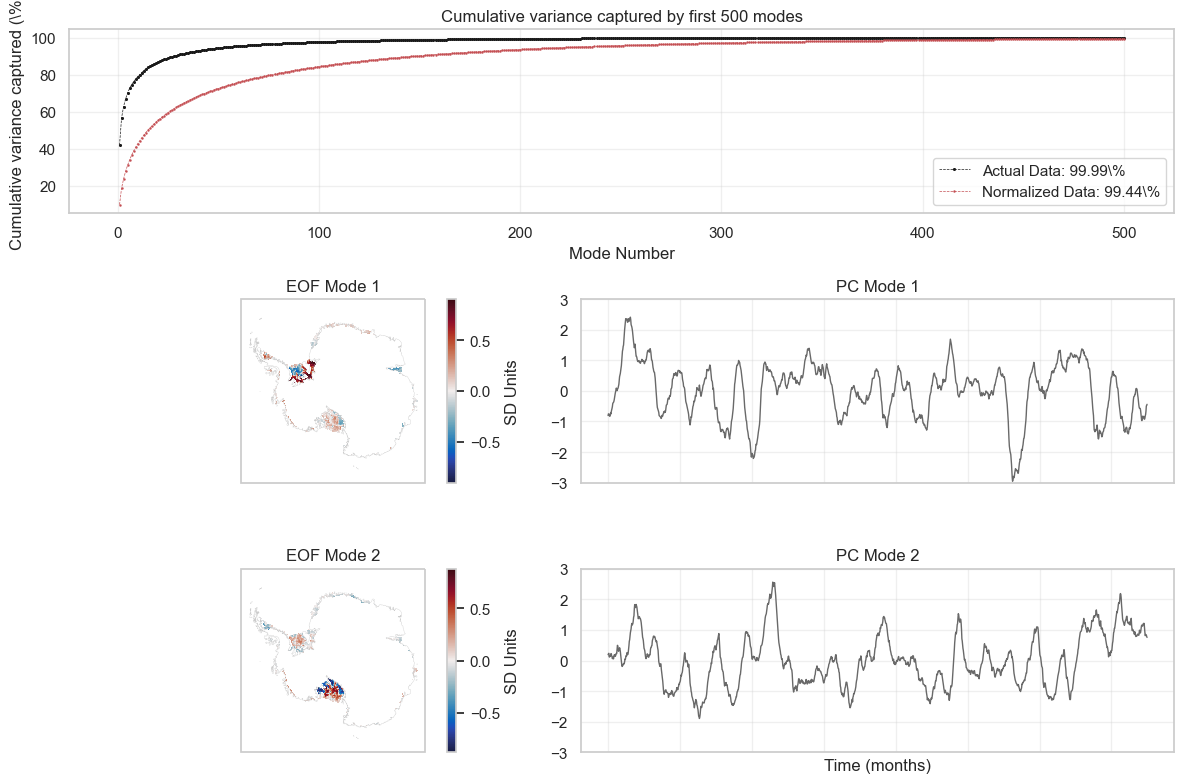

In [20]:
# Plot figure
# Figure: EOF modes from decomposition of normalized model variability data

nmodes_plot = 3 # Number of modes to plot

yr_length = range(0,125)
yrs_plot = np.repeat(yr_length, 12)

#sns.set_theme()
sns.set_theme(style="whitegrid")
fig=plt.figure(figsize=(12,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2])
axbig = fig.add_subplot(gs[0,:])
ax0 = [fig.add_subplot(gs[i,0],projection=crs) for i in range(1,nmodes_plot)]
ax1 = [fig.add_subplot(gs[i,1]) for i in range(1,nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    norm_eofs_eig.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a0.set_title('EOF Mode {}'.format(i+1))
    a1.set_ylim(-3,3)
    a1.plot(norm_pcs_eig.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')
    a1.set_title('PC Mode {}'.format(i+1))
    a1.tick_params(labelbottom=False, left=False, grid_alpha=0.3)

a1.set_xlabel('Time (months)');

m = 500
xvar = np.linspace(1,m,m)
axbig.plot(xvar,Fv_cs[:m]*100, 'k*--', lw=0.5,markersize=1.75,
         label='Actual Data: {:.2f}\%'.format(varexpl[:m].sum().values*100))
axbig.plot(xvar,Fvn_cs[:m]*100, 'rh--', lw=0.5,markersize=0.75,
         label='Normalized Data: {:.2f}\%'.format(norm_varexpl[:m].sum().values*100))
axbig.set_ylabel('Cumulative variance captured (\%)')
axbig.set_xlabel('Mode Number')
axbig.set_title('Cumulative variance captured by first {} modes'.format(m));
axbig.tick_params(labelbottom=True, left=False, grid_alpha=0.3)
axbig.legend();

fig.tight_layout()

## Fourier Phase Randomization

Now, the projection co-efficients from the previous step are phase-randomized to generate new realizations of the data. In this step, we sample phases for each FFT(PC) from (0,$2\pi$), and iterate to generate n realizations.

In [51]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 5
t_length = norm_pcs.shape[0]

# Define random number generator 
#rng = np.random.default_rng(2021)
#random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j) in line 26

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,norm_pcs.shape[0],norm_pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = norm_pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.vonmises(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
    print('calculated ifft for realization {}, all modes'.format(i))

calculated ifft for realization 0, all modes
calculated ifft for realization 1, all modes
calculated ifft for realization 2, all modes
calculated ifft for realization 3, all modes
calculated ifft for realization 4, all modes
CPU times: user 1.97 s, sys: 45 ms, total: 2.02 s
Wall time: 2.01 s


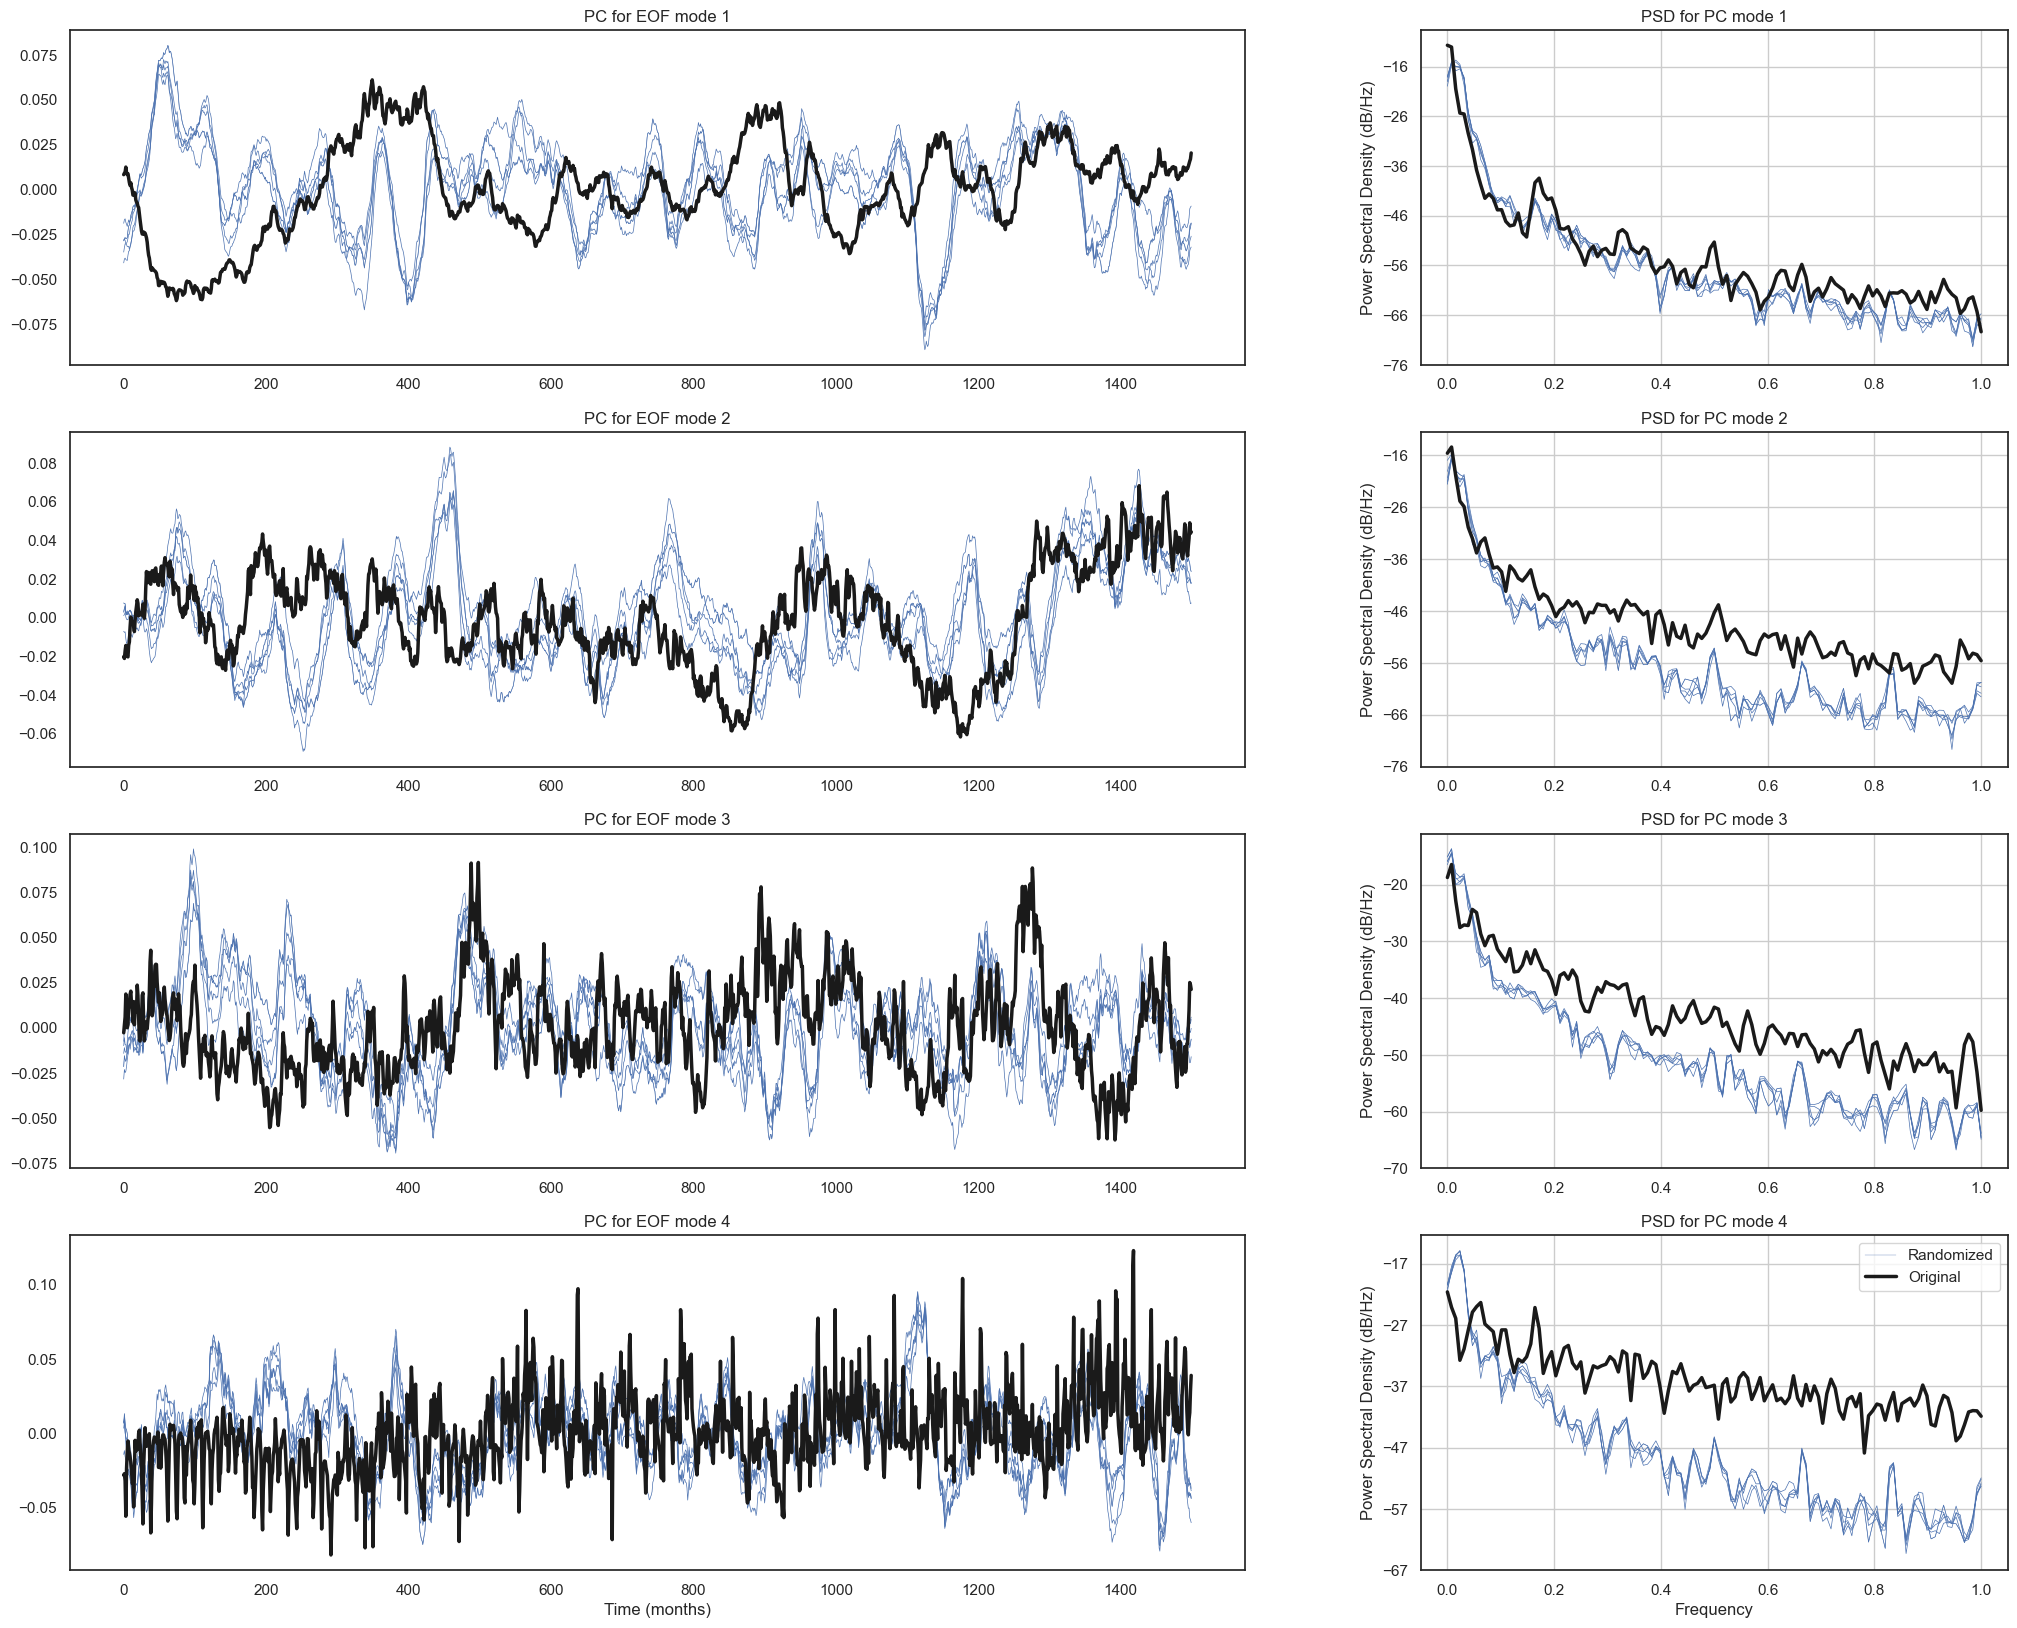

In [52]:
# Diagnostic plot of generated PCs

nmodes_plot = 4 # Number of modes to plot
nrealizations_to_plot = 5 # to be lesser than absolute total number, defined in the Fourier randomization step

sns.set_theme(style="white")
fig=plt.figure(figsize=(25,20))

gs = GridSpec(nmodes_plot, 2, width_ratios=[4, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0,a1) in enumerate(zip(ax0,ax1)):
    for n_realization in range(0,nrealizations_to_plot):
        a0.plot(new_fl[n_realization,:,i],color='b', linewidth=0.5)
        a1.psd(new_fl[n_realization,:,i],color='b', linewidth=0.5)
    a0.plot(new_fl[0,:,i],color='b', linewidth=0.25,label='Randomized')
    a1.psd(new_fl[0,:,i],color='b', linewidth=0.25,label='Randomized')
    a0.plot(pcs[:,i],color='k', linewidth=2.5,label='Original')
    a1.psd(pcs[:,i],color='k', linewidth=2.5,label='Original')
    a0.set_title('PC for EOF mode {}'.format(i+1))
    a1.set_title('PSD for PC mode {}'.format(i+1))
    a1.set_xlabel('')

a0.set_xlabel('Time (months)')
a1.set_xlabel('Frequency')
plt.legend();

### Helper Functions

Functions defined for the generation and follow on calculations

In [5]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    # mode can be any int in (1,nmodes), for cases 
    # when dimensionality reduction is preferred on the reconstructed dataset
    flux_reconstr = norm_model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

### Statistical Generation

This step uses functions committed to the `xeofs-rand` fork. *Ref: For commit diff details, see [mshiv/xeofs-rand](https://github.com/nicrie/xeofs/compare/main...mshiv:xeofs-rand:main).*

In [ ]:
# Generate dataset realizations

## Standard EOF/PCA implementation
# Can use the xeofs-rand package, or directly generate using sklearn PCA.

for i in range(n_realizations):
    flux_reconstr = generate_data(i, 1500, 1)
    flux_reconstr = (flux_reconstr*flux_clean_tstd)+flux_clean_tmean
    melt_reconstr = flux_reconstr*sec_per_year/rho_fw
    melt_reconstr = melt_reconstr.rename('rec{}'.format(n_realizations))
    melt_reconstr.to_netcdf(inDirName+"REC{}.nc".format(i))
    print('reconstructed realization # {}'.format(i))

In [ ]:
## Input generated dataset files
# This section presents a sample case of 1 generated realization
# Customize this section as necessary
rec0 = xr.open_dataset(inDirName+"REC0.nc").rec0

### Sparse PCA Implementation

[`sklearn.decomposition.SparsePCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html) was added to the `xeofs-rand` fork as a method.

`MiniBatchSparsePCA` can be used instead to improve computational speed.

In [38]:
##############################
# SPARSE DECOMPOSITION 
##############################

norm_model.solvesparse()
spca_eofs = model.eofs()
spca_pcs = model.pcs()

##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 3
t_length = pcs.shape[0]

# Define random number generator 
#rng = np.random.default_rng(2021)
#random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j) in line 26

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        #random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        #random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
    print('calculated ifft for realization {}, all modes'.format(i))

NameError: name 'norm_model' is not defined

In [ ]:
for i in range(n_realizations):
    new_fl_xr = xr.DataArray(new_fl[i], dims=pcs.dims, coords = pcs.coords, attrs = pcs.attrs)
    sparse_mini_rand = new_fl_xr @ spca_eofs.T
    # Imperative to check the above generated dataset for consistent dimensions
    sparse_mini_rand = sparse_mini_rand.transpose("time","y","x")
    sparse_mini_rand = (sparse_mini_rand*flux_clean_tstd)+flux_clean_tmean
    melt_spca_reconstr = sparse_mini_rand*sec_per_year/rho_fw
    melt_spca_reconstr = melt_spca_reconstr.rename('spcarec{}'.format(n_realizations))
    sparse_mini_rand.to_netcdf(inDirName+"spcaREC{}.nc".format(i))
    print("Created randomized realization...{}".format(i))

In [ ]:
## Input generated dataset files
# This section presents a sample case of 1 generated realization
# Customize this section as necessary
spcarec0 = xr.open_dataset(inDirName+"spcaREC0.nc").spcarec0

In [6]:
rec0 = xr.open_dataset(inDirName+interim_data_folder+"flux_reconstr_0.nc")
rec0 = rec0.reconstructed_data

rec1 = xr.open_dataset(inDirName+interim_data_folder+"flux_reconstr_1.nc")
rec1 = rec1.reconstructed_data

rec2 = xr.open_dataset(inDirName+interim_data_folder+"flux_reconstr_2.nc")
rec2 = rec2.reconstructed_data

rec3 = xr.open_dataset(inDirName+interim_data_folder+"flux_reconstr_3.nc")
rec3 = rec3.reconstructed_data

rec4 = xr.open_dataset(inDirName+interim_data_folder+"flux_reconstr_4.nc")
rec4 = rec4.reconstructed_data

In [9]:
"""
spcarec0 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"sparsemini_alpha0.1/sparsemini_REC_0.nc")
spcarec0 = spcarec0.__xarray_dataarray_variable__

spcarec1 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spca_a1/spca_a1_REC0.nc")
spcarec1 = spcarec1.__xarray_dataarray_variable__

spcarec2 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spca_a01/spca_a01_REC0.nc")
spcarec2 = spcarec2.__xarray_dataarray_variable__

spcarec3 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spca_a01/spca_a01_REC1.nc")
spcarec3 = spcarec3.__xarray_dataarray_variable__

spcarec4 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spcabatch_a1/spcabatch_a1_REC0.nc")
spcarec4 = spcarec4.__xarray_dataarray_variable__

spcarec5 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spcabatch_a3/spcabatch_a3_REC0.nc")
spcarec5 = spcarec5.__xarray_dataarray_variable__

spcarec6 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spcabatch_a3/spcabatch_a3_REC1.nc")
spcarec6 = spcarec6.__xarray_dataarray_variable__

spcarec7 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spcabatch_a10/spcabatch_a10_REC0.nc")
spcarec7 = spcarec7.__xarray_dataarray_variable__
"""

In [7]:
spcarec0 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spca_a01/spca_a01_REC0.nc")
spcarec0 = spcarec0.__xarray_dataarray_variable__

spcarec1 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spcabatch_a1/spcabatch_a1_REC0.nc")
spcarec1 = spcarec1.__xarray_dataarray_variable__

spcarec2 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spcabatch_a3/spcabatch_a3_REC0.nc")
spcarec2 = spcarec2.__xarray_dataarray_variable__

spcarec3 = xr.open_dataset(inDirName+
                           interim_data_folder+
                           cise_file_path+
                           std_file_path+"spcabatch_a3/spcabatch_a3_REC1.nc")
spcarec3 = spcarec3.__xarray_dataarray_variable__

In [33]:
spca_a01 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+
                           std_file_path+"sparsemini_alpha0.1/pcs.nc")
spca_a01 = spca_a01.PCs

spca_a1 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+
                          std_file_path+"spca_a1/sparse_pcs.nc")
spca_a1 = spca_a1.PCs

spca_a3 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+
                           std_file_path+"spcabatch_a3/pcs.nc")
spca_a3 = spca_a3.PCs

spca_a10 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+
                          std_file_path+"spcabatch_a10/pcs.nc")
spca_a10 = spca_a10.PCs

In [35]:
rs = spca_a01
df = pd.DataFrame(spca_a01[:,0:15])
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.089383,-0.091239,-0.120181,0.194138,-0.116251,-0.034540,-0.017805,0.100906,0.035035
1,-0.089383,1.000000,-0.047976,-0.091531,0.059557,0.001737,-0.079250,0.039093,-0.004430,-0.046564
2,-0.091239,-0.047976,1.000000,-0.012908,-0.043894,-0.021893,-0.031332,0.009025,0.065853,-0.067352
3,-0.120181,-0.091531,-0.012908,1.000000,-0.103987,0.019043,0.058792,-0.039686,-0.086302,-0.118860
4,0.194138,0.059557,-0.043894,-0.103987,1.000000,-0.039078,0.032042,0.064646,0.027381,0.103187
5,-0.116251,0.001737,-0.021893,0.019043,-0.039078,1.000000,-0.013244,-0.038369,-0.038172,-0.032191
6,-0.034540,-0.079250,-0.031332,0.058792,0.032042,-0.013244,1.000000,0.067090,-0.044995,-0.000939
7,-0.017805,0.039093,0.009025,-0.039686,0.064646,-0.038369,0.067090,1.000000,-0.095666,-0.021502
8,0.100906,-0.004430,0.065853,-0.086302,0.027381,-0.038172,-0.044995,-0.095666,1.000000,0.035288
9,0.035035,-0.046564,-0.067352,-0.118860,0.103187,-0.032191,-0.000939,-0.021502,0.035288,1.000000


In [37]:
rs = spca_a10
df = pd.DataFrame(spca_a10[:,0:100])
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


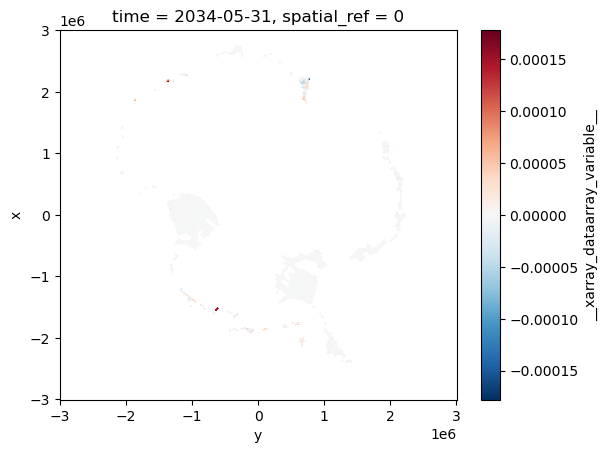

In [29]:
# spcarec2[100].plot() spca_a01/spca_a01_REC0.nc
# spcarec4[100].plot() spcabatch_a1/spcabatch_a1_REC0.nc
# spcarec5[100].plot() spcabatch_a3/spcabatch_a3_REC0.nc
# spcarec6[100].plot() spcabatch_a3/spcabatch_a3_REC1.nc

### Generator variability output 

For full AIS, and select basins: time series at a grid point and power spectral densities for the full ice shelf are plotted.

<xarray.DataArray 'timeMonthly_avg_landIceFreshwaterFlux' (time: 1500, y: 133,
                                                           x: 166)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lat          (y, x) float64 ...
    lon          (y, x) float64 ...
  * time         (time) datetime64[ns] 2026-01-31 2026-02-28 ... 2150-12-31
  * x            (x) float64 8e+05 8.1e+05 8.2e+05 ... 2.44e+06 2.45e+06
  * y            (y) float64 -1.2e+05 -1.1e+05 -1e+05 ... 1.19e+06 1.2e+06
    month        (time) int64 ...
    spatial_ref  int64 0

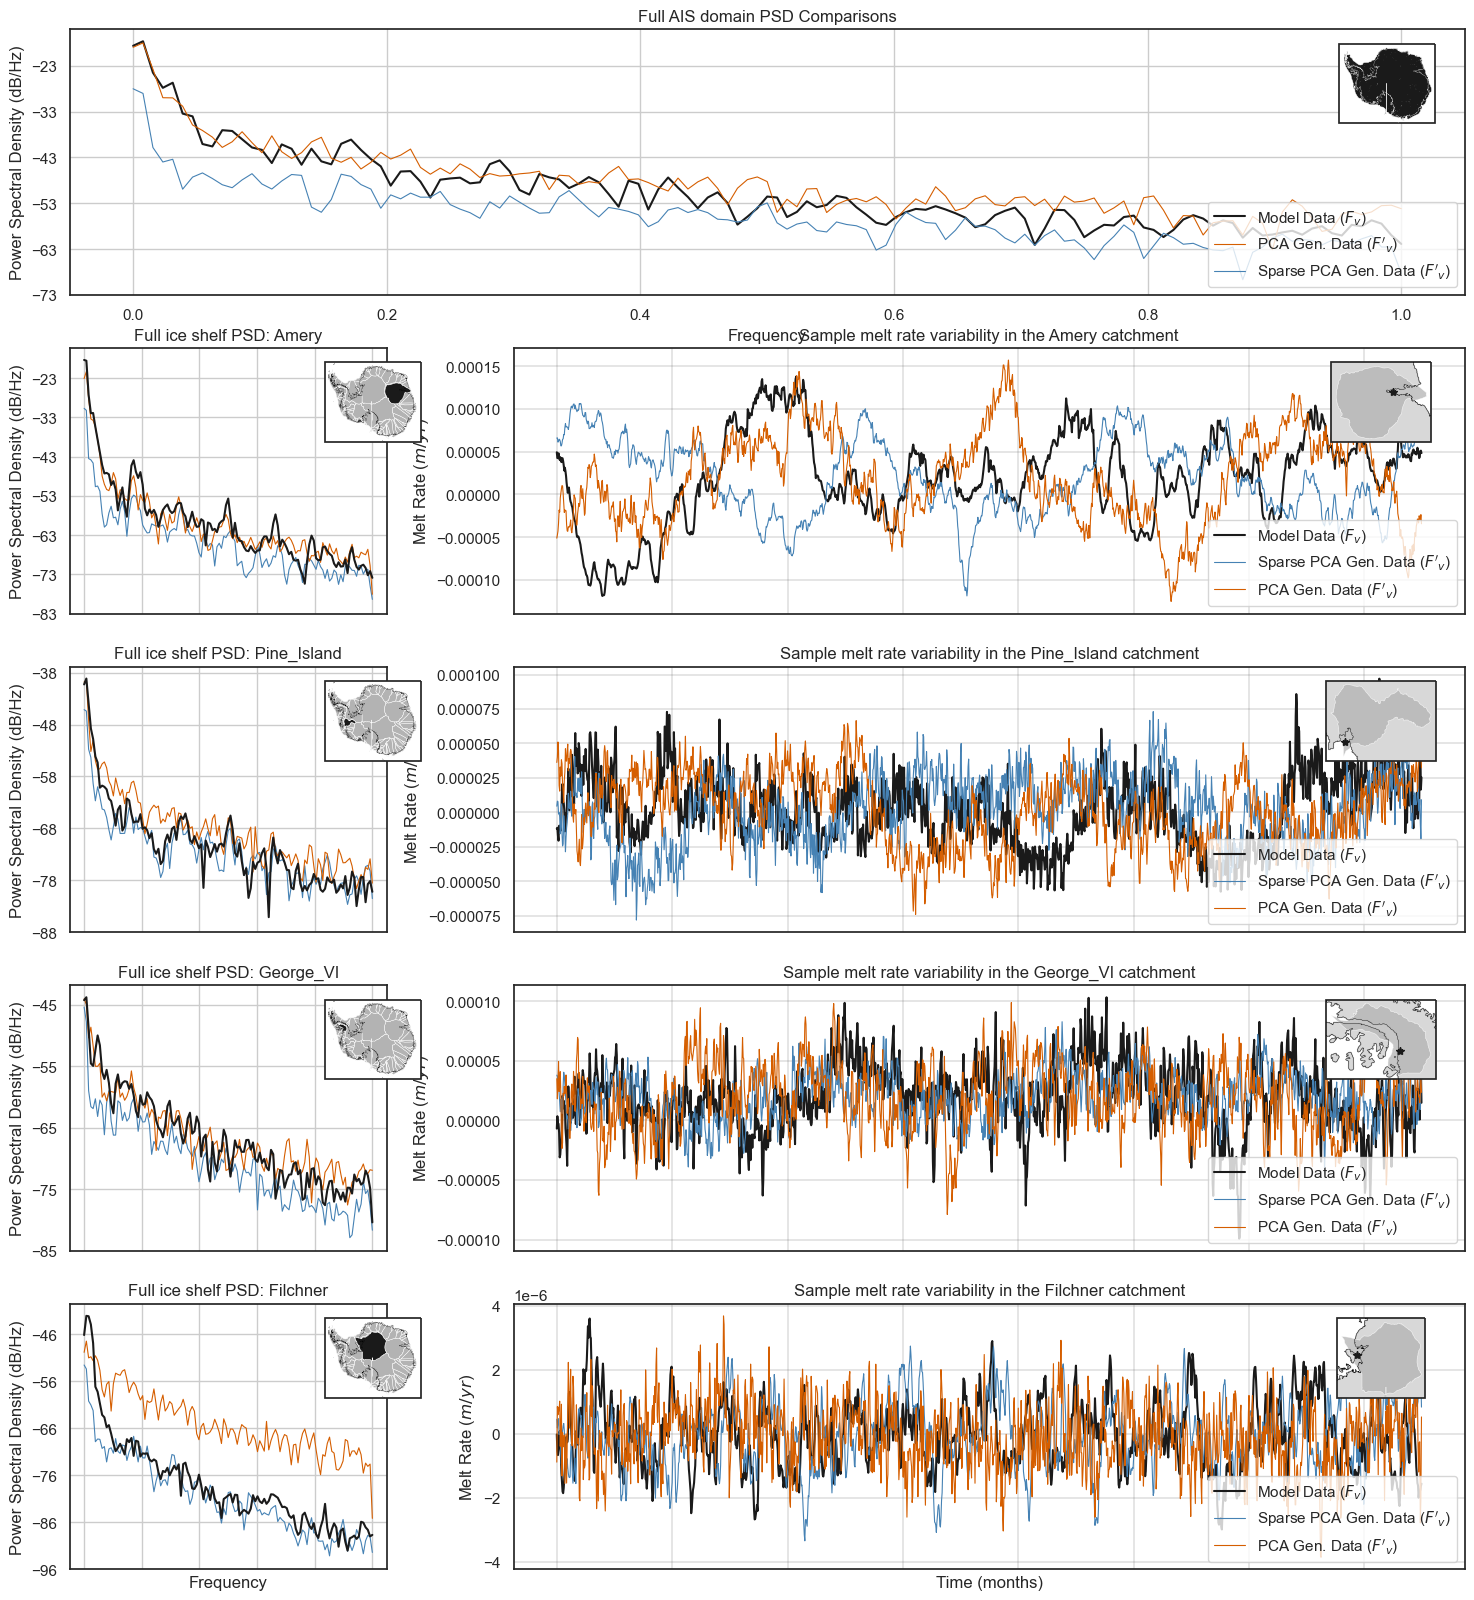

In [18]:
#catchments = np.array([1,27,28,61,70,83,94,71,22])
#basins = catchments+33

#basins = [34, 55, 60, 61, 94, 103]
#basins = [55,94]
#basins = [34, 60]
#grid_points = np.array(([85,105], [115,45], [4,45],[21,56], [11,10], [34,95]))
#grid_points = np.array(([115,45],[11,10]))
#grid_points = np.array(([85,105],[4,45]))

basins = [34,94,60,55,94]
# Choose grid points based on dataset indices. Can find these using data.x and data.y dimension arrays.
# Locations here have been selected based on performance of model simulation data at these points, 
# given also the variance between them (in terms of temporal scale of variability)
grid_points = np.array(([85,105], [11,10],[15,44], [100,40]))

#basins = np.array([34, 60, 94, 55])
# [2,3,4,5] = [Antarctica, Peninsula, West Antarctica, East Antarctica]

n_basins = len(basins)
oc = 'k'
pcac = '#D55E00'#'#FC8D62'
spcac = 'steelblue'#'#0072B2' #'#CC79A7'

lwbg = 0.1
lworig = 1.5
lwgen = 0.8

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,4*n_basins))
gs = GridSpec(n_basins, 2, width_ratios=[1,3])
axtop = fig.add_subplot(gs[0, :])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(1,n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(1,n_basins)]

for i,(a0,a1,grids) in enumerate(zip(ax0,ax1,grid_points)):
    orig = clip_data(flux_clean, basins[i])
    gen0 = clip_data(rec0, basins[i])
    spcagen0 = clip_data(spcarec0, basins[i])
    combined = xr.merge([orig,gen0,spcagen0])
    combined_ts = time_series(combined)
    a1.plot(orig[:,grids[0],grids[1]],color=oc, linewidth=lworig,label='Model Data ($F_v$)')
    a1.plot(spcagen0[:,grids[0],grids[1]],color=spcac, linewidth=lwgen,label='Sparse PCA Gen. Data ($F\'_v$)')
    a1.plot(gen0[:,grids[0],grids[1]],color=pcac, linewidth=lwgen, label='PCA Gen. Data ($F\'_v$)')
    axin1 = inset_axes(a1, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       bbox_to_anchor=(0.07,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    axin1.coastlines(resolution='10m',linewidth=0.25)
    axin1.add_feature(cartopy.feature.LAND, color='#B3B3B3',zorder=2,alpha=0.5)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin1,color='#B3B3B3',linewidth=0.4,alpha=0.75,zorder=3)
    axin1.coastlines(resolution='10m',linewidth=0.25,zorder=4)
    axin1.plot(orig.x[grids[1]],orig.y[grids[0]],marker='*',color='k',zorder=4)
    a1.set_title('Sample melt rate variability in the {} catchment'.format(icems.name[basins[i]]))
    a1.set_ylabel('Melt Rate ($m/yr$)');
    a1.set_xlabel('')
    a1.tick_params(labelbottom=False)
    a1.legend(loc="lower right");
    a1.grid(color='dimgray', linestyle='-', linewidth=0.25)
    a0.psd(combined_ts.__xarray_dataarray_variable__,color=spcac, linewidth=lwgen)
    a0.psd(combined_ts.reconstructed_data,color=pcac, linewidth=lwgen)
    a0.psd(combined_ts.timeMonthly_avg_landIceFreshwaterFlux,color=oc, linewidth=lworig)    
    axin0 = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       bbox_to_anchor=(-0.99,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axin0,linewidth=0.3,color='#B3B3B3')
    axin0.coastlines(resolution='10m',linewidth=0.15)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin0,color='k',linewidth=0.4, label="Selected Grid Point")
    a0.set_title('Full ice shelf PSD: {}'.format(icems.name[basins[i]]))
    a0.tick_params(labelbottom=False)
    a0.set_xlabel('')
    del orig, gen0, spcagen0, combined, combined_ts
a1.set_xlabel('Time (months)');
a0.set_xlabel('Frequency');

# Full AIS power spectral density plots
axtop.psd(time_series(flux_clean), color = oc, lw=lworig,label='Model Data ($F_v$)');
axtop.psd(time_series(rec0), color= pcac, lw=lwgen, label='PCA Gen. Data ($F\'_v$)');
axtop.psd(time_series(spcarec0), color= spcac, lw=lwgen,label='Sparse PCA Gen. Data ($F\'_v$)');
axintop = inset_axes(axtop, width="30%", height="30%", loc="upper right", 
                     bbox_to_anchor=(0.1,-0.025,1,1),bbox_transform=axtop.transAxes,
                     axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                     axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
icems[2:3].plot(ax=axintop,linewidth=0.3,color='k',alpha=1)
axintop.coastlines(resolution='10m',linewidth=0.15,color='white',zorder=5)
axtop.set_title('Full AIS domain PSD Comparisons');
axtop.legend(loc="lower right");

## Generator output with all components added

Generator output for a select few grid points in final output, with all components added back (Seasonality+draft dependence)

Use the following grid points to plot time series of original data and generated data. Grid point indices are specified for clipped subdomains. (Use `clip_data(data, basin_number)` and use the specified indices on the output).

Locations:
1. Amery (basin = 34) : `(y=85,x=105)`
2. George VI (basin = 60): `(y=4,x=45)`
3. Getz (basin = 61): `(y=21,x=58)`
4. Ronne (basin = 103): `(y=95,x=34)`

In [ ]:
# See notebook 06-sm-... for methods to obtain original dataset, 
# seasonality calculations and dedrafting datafile locations.

In [ ]:
# Ensure all datasets are in terms of melt rate [m/yr], not freshwater flux
F = flux*sec_per_year/rho_fw
Frec = rec0 + flux_seasonal + flux_drft
Fspcarec = spcarec0 + flux_seasonal + flux_drft

NameError: name 'clip_data' is not defined

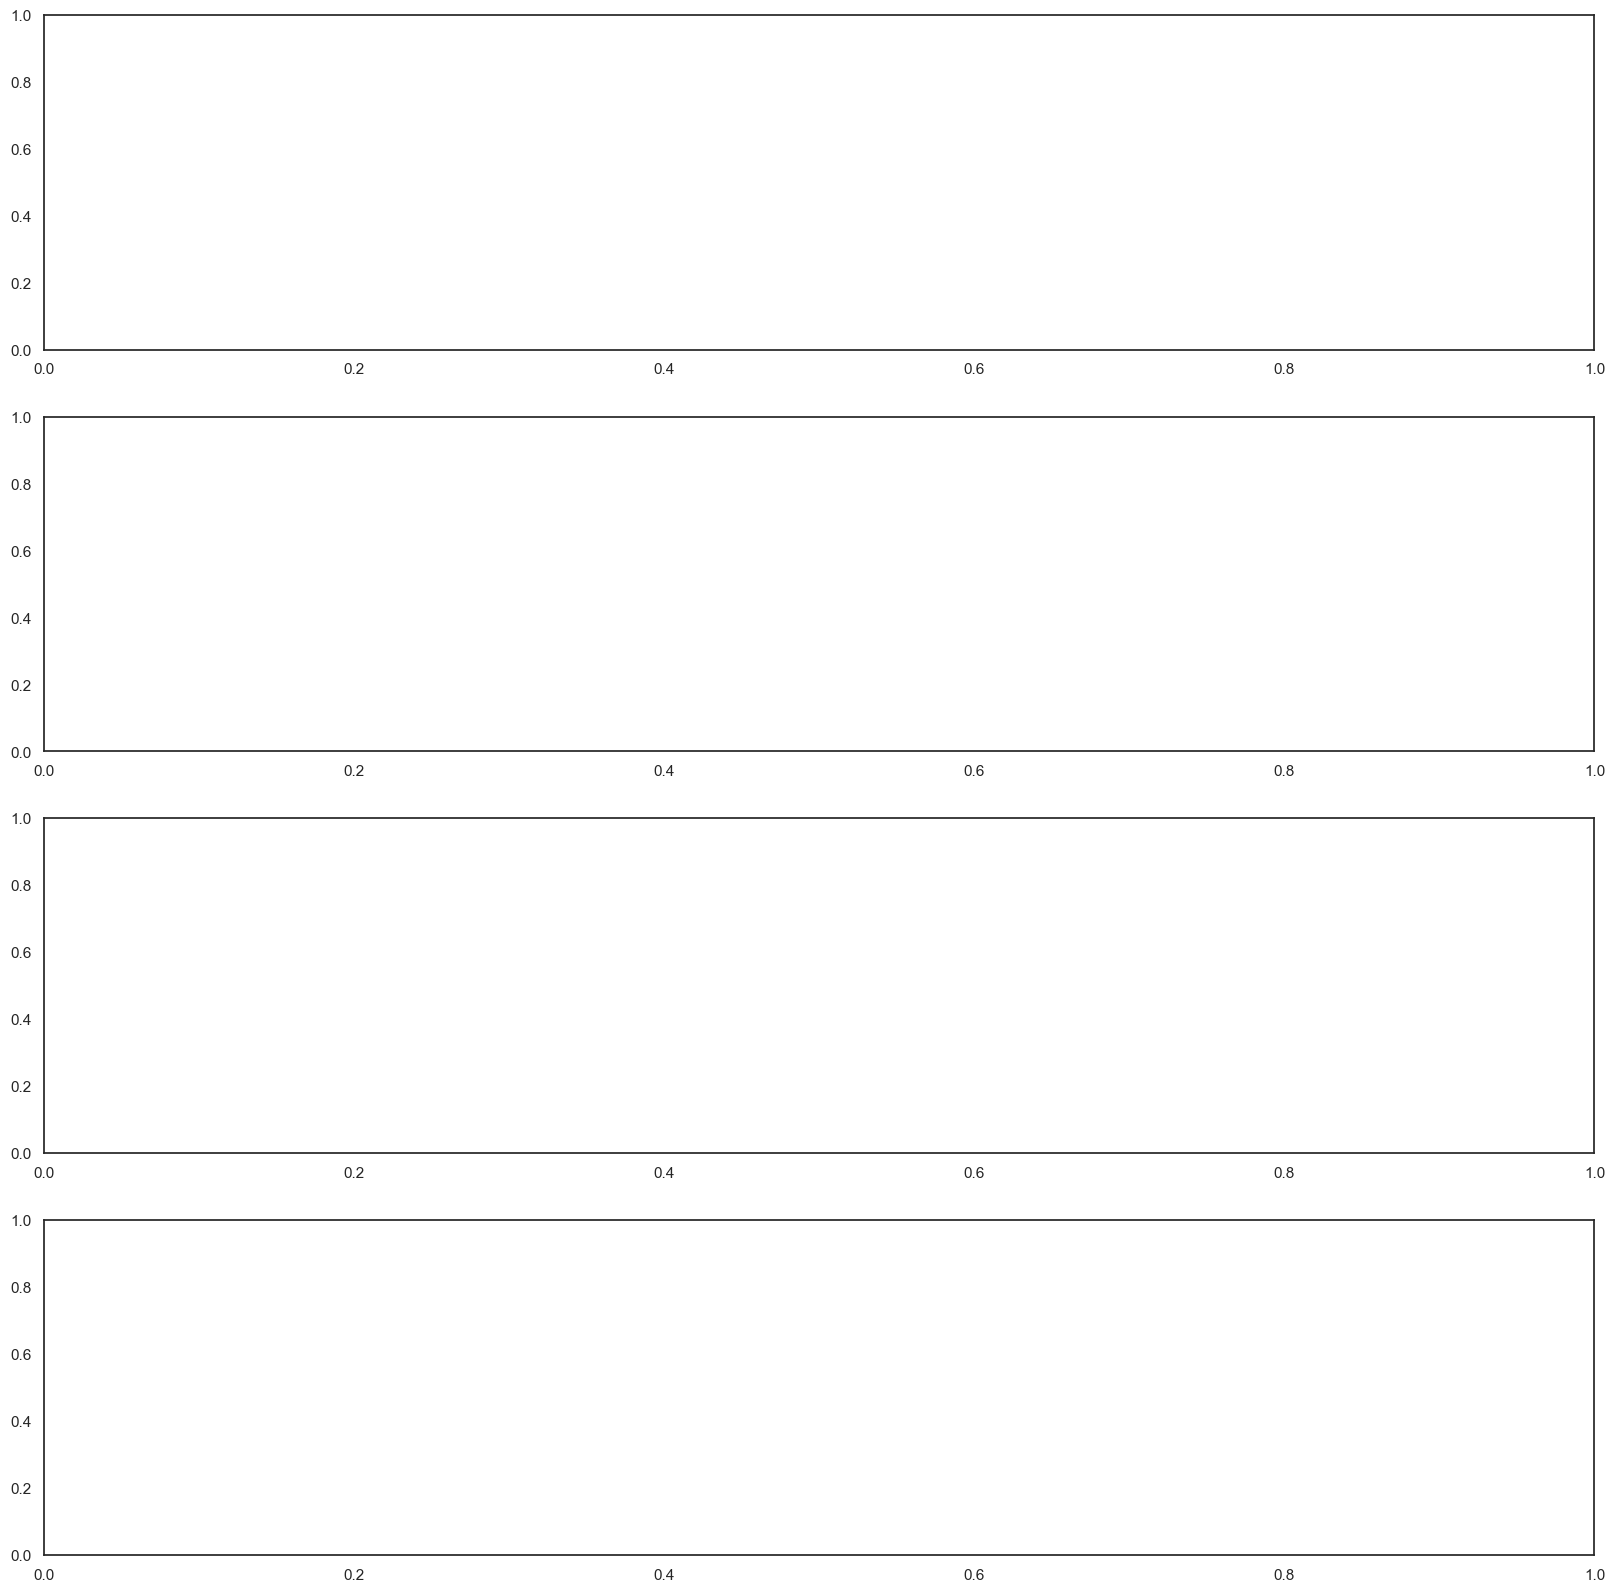

In [5]:
# ORIGINAL DATA
#orig = clip_data(flux, basin)
#basins = [34, 60, 61, 103]
#grid_points = np.array([[85,105],[4,45],[21,56],[95,34]])

basins = [34,94]
#grid_points = np.array(([85,105], [11,10],[15,44], [100,40]))
grid_points = np.array(([85,105], [11,10]))

basins = [34,94,60,55]
#grid_points = np.array(([85,105], [11,10],[15,44], [100,40]))
grid_points = np.array(([85,105], [11,10],[12,41], [100,40]))

sns.set_theme(style="white")

fig, axs = plt.subplots(4,1, figsize=[20, 20])
axs=axs.ravel()

pltlabels = ['(a)','(b)','(c)','(d)']

#n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

for i, grids in enumerate(zip(grid_points)):
    #ssnl = clip_data(flux_seasonal, basins[i])
    #drft = clip_data(flux_drft, basins[i])
    orig = clip_data(F, basins[i])
    spcarec = clip_data(Fspcarec, basins[i])
    axs[i].plot(orig[:,grids[0][0],grids[0][1]],color=oc, linewidth=lworig,label='Model Data ($F_{orig}$)')
    axs[i].plot(spcarec[:,grids[0][0],grids[0][1]],color=spcac, linewidth=lwgen,label='Sparse PCA Gen. Data ($F\'_{gen}$)')
    axs[i].set_title('Sample melt rate in the {} catchment'.format(icems.name[basins[i]]))
    axins = inset_axes(axs[i], width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       bbox_to_anchor=(0.1,-0.025,1,1),bbox_transform=axs[i].transAxes,
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    axins.add_feature(cartopy.feature.LAND, color='#B3B3B3',zorder=2,alpha=0.5)
    icems.loc[[basins[i]],'geometry'].plot(ax=axins,color='#B3B3B3', linewidth=0.45,zorder=3)
    axins.coastlines(resolution='10m',linewidth=0.25,zorder=4)
    axins.plot(orig.x[grids[0][1]],orig.y[grids[0][0]], marker='*', color='k',zorder=4)
    axs[i].set_ylabel('Melt Rate ($m/yr$)');
    axs[i].set_xlabel('');
    axs[i].legend(loc="lower right");
    axs[i].grid(color='dimgray', linestyle='-', linewidth=0.2)
    del rec01, rec1, rec3a

axs[3].set_xlabel('Time (months)');